2025-08-12 13:22:48.775836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755004968.985498      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755004969.051259      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Total images found: 3264
class
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64
📊 Train: 2219, Val: 392, Test: 653
Found 2219 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


I0000 00:00:1755004985.358065      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1755004994.141264      97 service.cc:148] XLA service 0x7c0994007430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755004994.142028      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755004994.817514      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755005014.656388      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 79s 763ms/step - accuracy: 0.3223 - loss: 1.7735 - val_accuracy: 0.4158 - val_loss: 1.2909
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - accuracy: 0.3973 - loss: 1.2581 - val_accuracy: 0.4541 - val_loss: 1.2039
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 410ms/step - accuracy: 0.4224 - loss: 1.1989 - val_accuracy: 0.4974 - val_loss: 1.1489
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 417ms/step - accuracy: 0.4577 - loss: 1.1229 - val_accuracy: 0.5689 - val_loss: 0.9846
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.5236 - loss: 1.0512 - val_accuracy: 0.5740 - val_loss: 1.0122
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 407ms/step - accuracy: 0.6306 - loss: 0.9048 - val_accuracy: 0.7066 - val_loss: 0.9558
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 408ms/step - accuracy: 0.7197 - loss: 0.7274 - val_accuracy: 0.7908 - val_loss: 0.6197
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.8138 - loss: 0.4979 - val_accuracy: 0.826

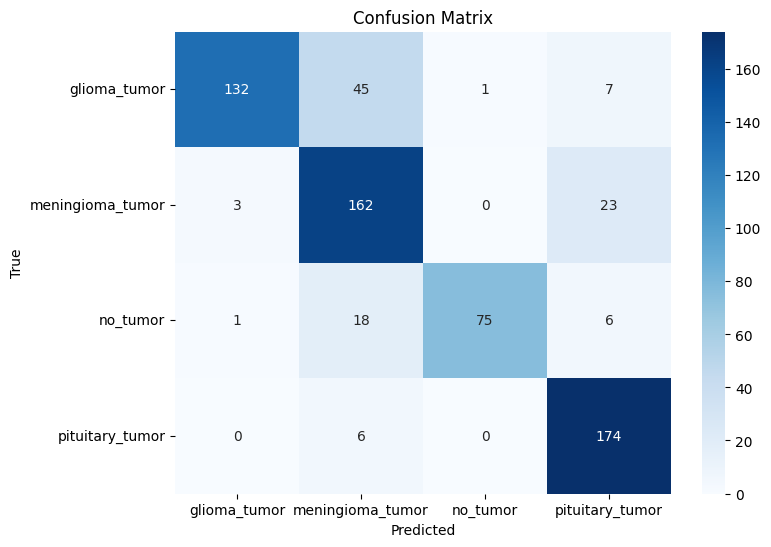

📊 Manual Accuracy: 83.15%


In [1]:
# ✅ Step 1: Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns

# ✅ Step 2: Paths & Parameters
DATASET_PATH = "/kaggle/input/sartaj-dataset"  # Update if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# ✅ Step 3: Load image paths and labels (recursive search)
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path not found: {DATASET_PATH}")

# Search recursively for images
image_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    image_paths.extend(glob.glob(os.path.join(DATASET_PATH, "**", ext), recursive=True))

labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Create dataframe
df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images found: {len(df)}")
if len(df) == 0:
    raise ValueError("❌ No images found. Check your dataset path or folder structure.")
print(df['class'].value_counts())

# ✅ Step 4: Split into train, val, test
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ✅ Step 5: ImageDataGenerators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True)

val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_gen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                           target_size=IMG_SIZE, class_mode='categorical',
                                           batch_size=BATCH_SIZE)

val_flow = val_test_gen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, class_mode='categorical',
                                            batch_size=BATCH_SIZE)

test_flow = val_test_gen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                             target_size=IMG_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, shuffle=False)

# ✅ Step 6: Build the VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
num_classes = len(train_flow.class_indices)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ Step 7: Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Step 8: Train
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_vgg16_model.keras", save_best_only=True)
]

history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# ✅ Step 9: Evaluate
loss, acc = model.evaluate(test_flow)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# ✅ Step 10: Predictions
y_true = test_flow.classes
y_pred = np.argmax(model.predict(test_flow), axis=1)
labels = list(test_flow.class_indices.keys())

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ✅ Step 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# ✅ Step 12: Manual Overall Accuracy
correct_preds = np.sum(y_pred == y_true)
total_preds = len(y_true)
manual_acc = correct_preds / total_preds
print(f"📊 Manual Accuracy: {manual_acc * 100:.2f}%")
